In [1]:
import numpy as np
import matplotlib.pyplot as plt

from astropy.io import fits
from astropy.table import Table

import pandas as pd
import seaborn as sns

sns.set(context="talk", style="ticks", palette="hls", color_codes=True)

from MaStarChecks.constants import NAN_PLACEHOLDER
from MaStarChecks.io import load_libraries, write_basis_parameters, write_basis_seds, write_fit3d_basis
from MaStarChecks.plotting.styles import *


Y_COLUMNS = ["TEFF", "LOGG", "MET", "ALPHAM"]
Y_UNITS = ["log/K", "log/cm/s^2", "[Fe/H]", "[alpha/Fe]"]

In [2]:
# read MaStar catalogue
# bin the parameter space:
#   - using a regular binning
#   - using a percentile binning
# compute average properties within bins
# compute average spectra withing bins
# compute propagated errors within bins
# write output templates to disk

In [3]:
libraries, catalogues = load_libraries(
    labels=["MaStar"],
    kind="classified-gsl",
    spectra_types=["FLUX", "ERROR"],
    libraries_path="../fitting/_data/classified-mastar-v3.1.2-cleaned-v2-gsl",
    use_cache=True, cache_path="_cache", cache_label="classified-v3.1.2"
)

mastar_catalogue = catalogues["MaStar"]
mastar_spectra, mastar_errors = libraries["MaStar"]["FLUX"], libraries["MaStar"]["ERROR"]

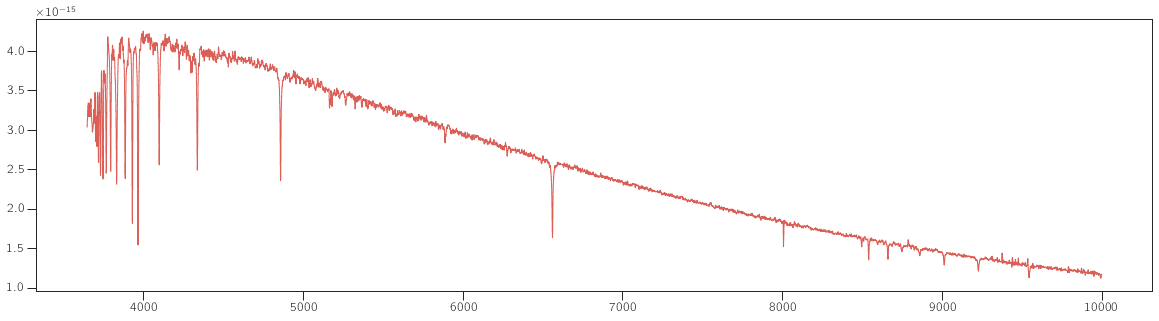

In [4]:
mastar_wl = mastar_spectra.columns
mastar_spectra = mastar_spectra.values * mastar_catalogue["FNORM"].values[:, None]
mastar_errors = mastar_errors.values * mastar_catalogue["FNORM"].values[:, None]


plt.figure(figsize=(20,5))
plt.step(mastar_wl, mastar_spectra[0], lw=1)

In [5]:
nwl = mastar_wl.size

wl_b = (3600, 4000) #mastar_wl[[0, nwl//3-1]]
wl_r = (4500, 5000) #mastar_wl[[nwl//3, 2*nwl//3-1]]
wl_i = (8500, 9500) #mastar_wl[[2*nwl//3, -1]]

mask_b = (wl_b[0] <= mastar_wl) & (mastar_wl <= wl_b[1])
mask_r = (wl_r[0] <= mastar_wl) & (mastar_wl <= wl_r[1])
mask_i = (wl_i[0] <= mastar_wl) & (mastar_wl <= wl_i[1])

snr_b = np.nanmean(np.divide(mastar_spectra, mastar_errors, where=mastar_errors!=0)[:, mask_b], axis=1)
snr_r = np.nanmean(np.divide(mastar_spectra, mastar_errors, where=mastar_errors!=0)[:, mask_r], axis=1)
snr_i = np.nanmean(np.divide(mastar_spectra, mastar_errors, where=mastar_errors!=0)[:, mask_i], axis=1)

min_snr = 100
mask_clean = (snr_b>min_snr)&(snr_r>min_snr)&(snr_i>min_snr)
mask_clean = mask_clean & (mastar_spectra>0).all(axis=1)
mastar_catalogue = mastar_catalogue.loc[mask_clean]
mastar_spectra = mastar_spectra[mask_clean]

Text(0, 0.5, 'Counts')

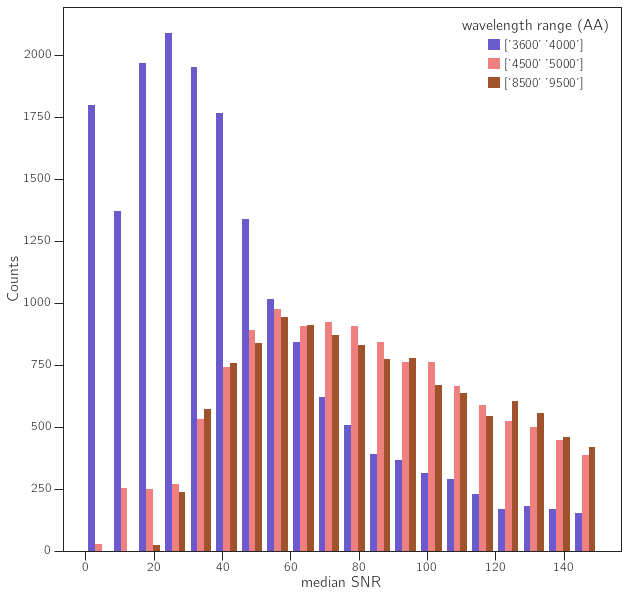

In [6]:

plt.hist((snr_b, snr_r, snr_i), bins=20, range=(0,150), color=("slateblue", "lightcoral", "sienna"), label=(wl_b, wl_r, wl_i))
plt.legend(loc=0, frameon=False, title="wavelength range (AA)")
plt.xlabel("median SNR")
plt.ylabel("Counts")


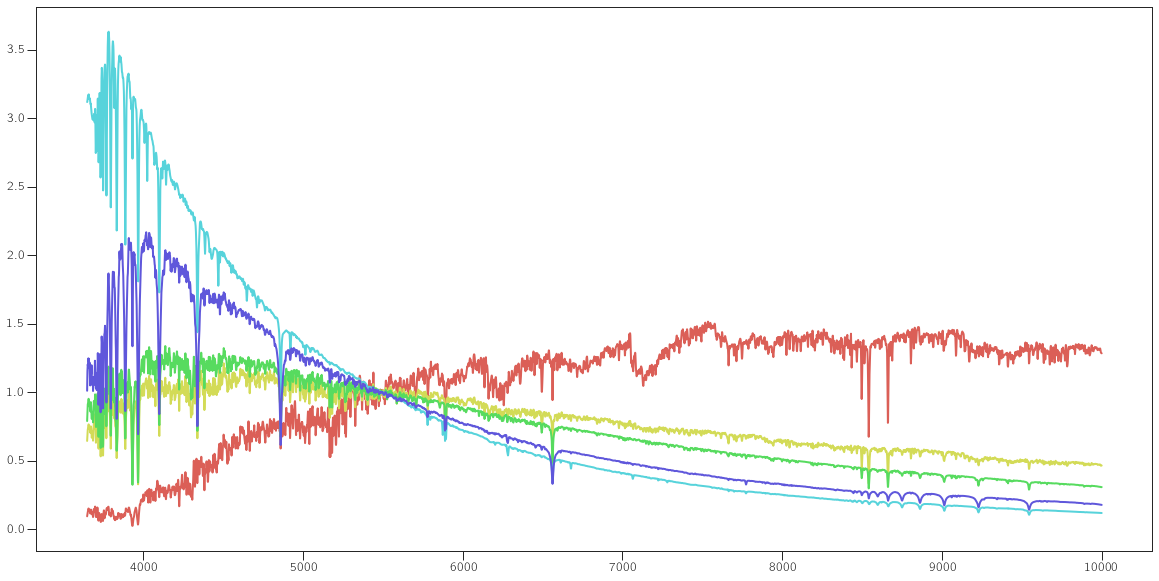

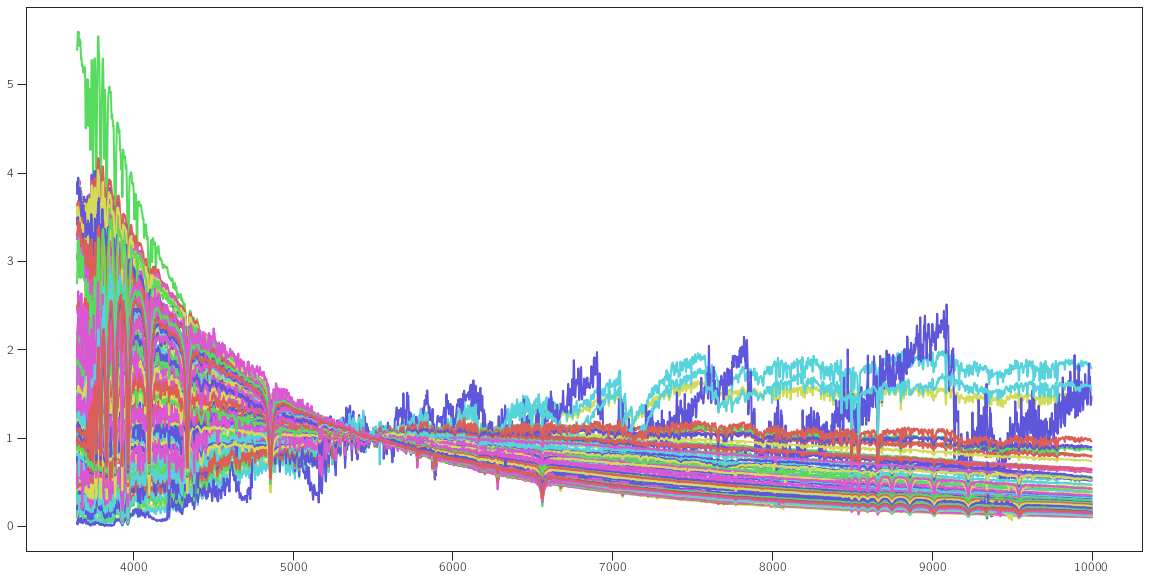

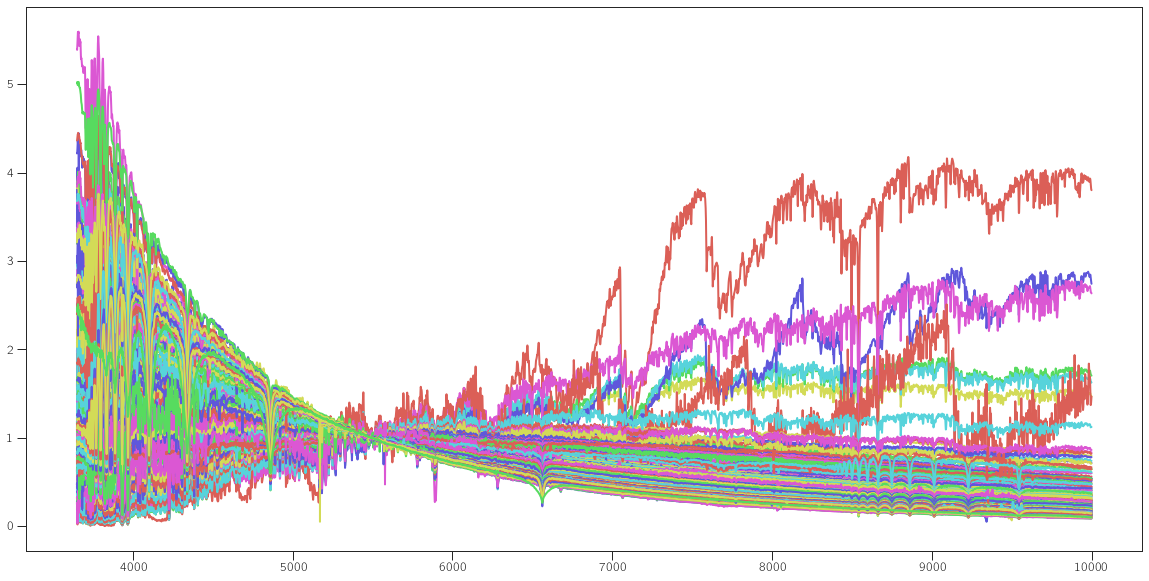

In [8]:
from itertools import product


norm_mask = (5490<=mastar_wl)&(mastar_wl<=5510)

columns = ["TEFF", "LOGG", "MET", "ALPHAM"]
y = mastar_catalogue.filter(items=columns).values

for nbins in [(2,3,1,1), (5,5,4,3), (10,10,4,2)]:
    H, edges = np.histogramdd(y, bins=nbins)

    params = []
    spectra = []
    for i, j, k, m in product(*[range(nbin) for nbin in nbins]):
        mask = (
            ((edges[0][i] <= y[:,0])&(y[:,0] < edges[0][i+1])) &
            ((edges[1][j] <= y[:,1])&(y[:,1] < edges[1][j+1])) &
            ((edges[2][k] <= y[:,2])&(y[:,2] < edges[2][k+1])) &
            ((edges[3][m] <= y[:,3])&(y[:,3] < edges[3][m+1]))
        )
        if mask.sum() == 0: continue
        
        spectra_i = np.mean(mastar_spectra[mask], axis=0)

        fnorm = np.median(spectra_i[norm_mask])

        params_i = np.mean(y[mask], axis=0).tolist()
        params_i += [fnorm]

        spectra_i /= fnorm

        params.append(params_i)
        spectra.append(spectra_i)

    params = np.asarray(params)
    spectra = np.asarray(spectra)

    plt.figure(figsize=(20,10))
    plt.plot(mastar_wl, spectra.T)

    basis_hdus = write_basis_seds(
        seds=spectra,
        wavelengths=mastar_wl,
        norm_wlength=5500,
        basis_params=params,
        columns=Y_COLUMNS+["FNORM"],
        units=Y_UNITS+["erg/s/cm^2/AA"],
        label=f"binned-{len(spectra)}-mastar",
        path="../../../lvm-dap/_fitting-data/_basis-binned_mastar"
    )
    fit3d_hdus = write_fit3d_basis(
        seds=spectra,
        wavelengths=mastar_wl,
        norm_wlength=5500,
        basis_params=params,
        columns=Y_COLUMNS+["FNORM"],
        units=Y_UNITS+["erg/s/cm^2/AA"],
        label=f"binned-{len(spectra)}-mastar",
        path="../../../lvm-dap/_fitting-data/_basis-binned_mastar"
    )
